Authors:
- Thomas Vray: 474 290
- Bryan Francois: 524 191
- Wassim Al Khouri: 513 160

In [1]:
# Import libraries
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, os, glob

# Introduction


Interpreter Scheduling Problems (ISP) are increasingly relevant in today’s globalized and multicultural society. These problems arise in various critical domains such as healthcare, legal systems, and international or urban institutional meetings, where multilingual communication is essential for effective interaction. Poor scheduling or mismanagement of interpreters can lead to serious consequences: for example, a patient might be unable to accurately describe their symptoms during a medical consultation, potentially endangering their life. In legal or political contexts, miscommunication due to interpreter shortages or mismatches can result in misunderstandings, delays, or even violations of fundamental rights.
 
Effective interpreter scheduling is a complex task that must balance interpreter availability, language coverage, fairness of workload distribution, and institutional constraints. Unlike automated translation systems which are not yet 100% reliable and often fail to capture nuance in real-time spoken interaction human to interpreters remain essential in high-stakes or sensitive environments. Thus, the goal is to develop robust schedules that maximize language pair coverage while also being flexible enough to handle unforeseen events such as sudden changes in availability or last-minute session modifications.
 
Several research papers have addressed interpreter scheduling problems by proposing various mathematical and algorithmic approaches, including integer programming, stochastic modeling, and heuristic optimization.
 
In this work, our objective is to explore and solve a realistic Interpreters Scheduling Problem (ISP). The setting involves a group of interpreters working for an institution, each proficient in a specific set of languages. These interpreters must be assigned to various sessions (grouped in blocks), where speakers communicate exclusively in their native languages. Interpreters are essential to ensure mutual understanding between participants. The main goal is to maximize the coverage of language pairs across all sessions, while respecting a range of logical and operational constraints. Additionally, we investigate advanced mechanisms such as bridging, which allows interpreters to indirectly connect languages through a shared intermediary.

## Bibliogrpahy

- **Chu, Sydney C K.**  
    *Staffing Model for Scheduling Simultaneous Interpreters under Tight Constraints*  
    The Government Secretariat of Hong Kong faces increasing demand for simultaneous interpretation (SI) services, leading to tight manpower scheduling. The study addresses workload balancing, equitability, and feasibility versus optimality in a many-rule setting, using optimization modeling and computer implementation.  
    [PDF available locally]
 
- **Ahmed, Abdulaziz & Hamasha, Mohammad M. (2018).**  
    *Scheduling Language Interpreters at a Medical Center: An Integer Programming Approach*  
    This paper develops an integer linear programming model to optimize interpreter assignments in medical centers, aiming to minimize staffing costs while ensuring interpreter availability.  
    [Read more](https://www.proquest.com/docview/2553579198/abstract/45D7F3C6942447B7PQ/1)
 
- **Smith, Stephen F. (2005).**  
    *Is Scheduling a Solved Problem?*  
    In: Multidisciplinary Scheduling: Theory and Applications. Boston, MA: Springer US, pp. 3–17.  
    Discusses the advances and remaining challenges in scheduling research, highlighting the complexity and context-dependence of real-world scheduling problems.  
    [DOI: 10.1007/0-387-27744-7_1](https://doi.org/10.1007/0-387-27744-7_1)
 
- **Ahmed, Abdulaziz & Frohn, Elizabeth (2021).**  
    *A predictive and prescriptive analytical framework for scheduling language medical interpreters*  
    Health Care Management Science, 24(3), 531–550.  
    Proposes a framework combining predictive modeling for demand forecasting and multi-objective integer programming for interpreter scheduling in healthcare, aiming to minimize costs and maximize service quality and interpreter utilization.  
    [DOI: 10.1007/s10729-020-09536-y](https://doi.org/10.1007/s10729-020-09536-y)
 
- **Interpreter Instruction Scheduling**  
    *(PDF) Interpreter Instruction Scheduling*  
    [Read online](https://www.researchgate.net/publication/221302660_Interpreter_Instruction_Scheduling)

# Formulation

## Parameters

<div style="display: flex; flex-wrap: wrap;">
 
<div style="flex: 1; min-width: 300px;">
 
- **I**: Set of interpreters  
- **L**: Set of languages spoken  
- **L<sub>i</sub>** ⊆ **L**: Set of languages spoken by interpreter *i*  
 
</div>
<div style="flex: 1; min-width: 300px;">
 
- **B**: Set of one-hour blocks (|B| = 40)  
- **S<sub>b</sub>**: Set of simultaneous sessions during block *b* (held in different rooms)  
- **S**: Full set of sessions  
- **U<sub>s</sub>**: Set of languages used in session *s*
 
</div>
</div>

## 1.Simple IP (model 1)

<b>LP</b> represents all the possible pairwise combinations of languages spoken in a set of languages.

<b>X_{bsli}</b> represents the assignment of interpreter <b>i</b> to session <b>s</b> for language pair <b>l</b> in the block <b>b</b>.

### OF1

In order to maximize the total number of languages pairs covered:
$$ \max \sum_{i\in I} \sum_{b \in B}\sum_{s \in S(b)} \sum_{l \in (LP(s) \cap LP(i))} X_{bsli} $$

<b>Subject to:</b>

$$\sum_{s \in S(b)}\sum_{l \in (LP(s) \cap LP(i))} X_{bsli} \leq 1 \quad \forall i, b $$

$$\sum_{i \in I} X_{bsli} \leq 1 \quad\forall b, s, l $$

### OF2

For the second objective function, we introduced a new binary variable describing if all pair of languages are covered or not in a session $SC_{bs}$:

$$ 
    \max \sum_{b \in B}\sum_{s \in S(b)} SC_{bs} 
$$

<b>Subject to:</b>

$$
    \sum_{s \in S(b)}\sum_{l \in (LP(s) \cap LP(i))} X_{bsli} \leq 1 \quad \forall i, b
$$
$$
    \sum_{i \in I} X_{bsli} \leq 1 \quad\forall b, s, l 
$$
$$
    SC_{bs} \leq \frac{1}{|LP(s)|} \sum_{i \in I} \sum_{l \in (LP(s) \cap LP(i))} X_{bsli} \quad \forall b, s
$$

### model 1

In [2]:
def Model_1(data, OBJ_FUNC=1):
    model = gp.Model("model1")
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]


    idx = [
        (b, s, l, i)
        for b in Blocks
        for s in Sessions_blocks[b]
        for l in Pairwise_languages_sessions[s]          # l = (l1,l2)
        for i in Interpreters
        if l[0] in Languages_interpreters[i] and l[1] in Languages_interpreters[i]
    ]
    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = model.addVars(idx, vtype=GRB.BINARY)
    session_covered = model.addVars(Sessions, vtype=GRB.BINARY)
    # Add constraints
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(assign.sum(b, '*', '*', i) <= 1)
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(assign.sum(b, s, l, '*') <= 1)
            
    #Session covered if all languages are covered
    for s in Sessions:
        total_languages = len(Pairwise_languages_sessions[s])
        model.addConstr(session_covered[s] <= assign.sum('*', s, '*', '*') / total_languages)     
    

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(assign.sum('*', '*', '*', '*'), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(session_covered.sum('*'), GRB.MAXIMIZE)
    
    return model

## 2. Some operational constraints (model 2)

We added 2 new constrains to our model:

### OC1

Each interpreter can be assigned to at most 15 sessions
$$
    \sum_{b \in B}\sum_{s \in S(b)}\sum_{l \in (LP(s) \cap LP(i))} X_{bsli} \leq 15 \quad \forall i
$$

### OC2

Each interpreter cannot work during more than 3 consecutives blocks
$$
    \sum_{b \in B'}\sum_{s \in S(b)}\sum_{l \in (LP(s) \cap LP(i))} X_{bsli} \leq 3 \quad \forall i, B'
$$
$B'$ are all sets of 4 consecutives blocks of B

### model 2

In [3]:
def Model_2(data, OBJ_FUNC=1):
    model = gp.Model("model2")
    
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [(l1, l2) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]

    # Create index for variables
    idx = [
        (b, s, l, i)
        for b in Blocks
        for s in Sessions_blocks[b]
        for l in Pairwise_languages_sessions[s]          # l = (l1,l2)
        for i in Interpreters
        if l[0] in Languages_interpreters[i] and l[1] in Languages_interpreters[i]
    ]
    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = model.addVars(idx, vtype=GRB.BINARY)
 
    session_covered = model.addVars(Sessions, vtype=GRB.BINARY)
    # Add constraints
    
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(assign.sum(b, '*', '*', i) <= 1)
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(assign.sum(b, s, l, '*') <= 1)
            
    #Session covered if all languages are covered
    for s in Sessions:
        total_languages = len(Pairwise_languages_sessions[s])
        model.addConstr(session_covered[s] <= assign.sum('*', s, '*', '*') / total_languages)

    #Max 15 hours per interpreter
    for i in Interpreters:
        model.addConstr(assign.sum('*', '*', '*', i) <= 15)
    
    # Max 3 sessions in a row per interpreter
    for idx in range(len(Blocks) - 3):
        window = Blocks[idx:idx + 4]
        for i in Interpreters:
            model.addConstr(assign.sum(window, '*', '*', i) <= 3)
            
    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(assign.sum('*', '*', '*', '*'), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(session_covered.sum('*'), GRB.MAXIMIZE)
    return model

## 3.Bridging

In the model 3 we allowed bridging. This means that an 2 interpreters can be used to translate from l1 to l2 using a language they both speak l'. We had to change our formulation to meet this new challenge.
First, we introduced a new variable $Y_{bsli_1i_2l'}$ which describes if there is a bridge between i_1 and i_2 for language the pair of language l using $l'$ to communicate. We had to change the objective function (OF1) with a new variable ($LC_{b, s,l}$).

### OF1


$$ \max \sum_{b \in B}\sum_{s \in S(b)}\sum_{l \in LP(s)} LC_{bsl} $$

<b>Subject to:</b>

One interpreter can translate only one session and only one pair of language at a time
$$
    \sum_{s \in S(b)}\sum_{l \in (LP(s) \cap LP(i))} X_{bsli} \leq 1 \quad \forall i, b
$$

An interpreter can only be part of one bridge at the time
$$
    \sum_{i_2 \gt i_1} \sum_{l \in LP(s)} \sum_{l' \in (LP(i_1) \cap LP(i_2))} Y_{bsli_1i_2l'} \leq 1 \quad \forall b, s, i_1 
$$

Link between bridge and assignments
$$Y_{bsli_1i_2l'} \leq X_{bs(l_1,l')i_1}$$
$$Y_{bsli_1i_2l'} \leq X_{bs(l_2,l')i_2}$$

Each session can have only one interpreter per language pair
$$ 
    \sum_{i \in I} X_{bsli} \leq 1 \quad\forall b, s, l 
$$

Language pair covered constraint
$$
    LC_{bsl} \leq \sum_{i \in I} X_{bsli} + \sum_{i_1 \in I} \sum_{i_2 \gt i_1} Y_{bsli_1i_2l'} \quad \forall b, s, l
$$

### OF2

Same formulation but we changed the constraint on the session covered by:
$$
    SC_{bs} \leq \frac{1}{|LP(s)|} \sum_{l \in LP(s)} LC_{bsl} \quad \forall b, s
$$

### model 3

In [4]:
def Model_3(data, OBJ_FUNC=1):
    #Bridge implementation
    model = gp.Model("model with bridge")
    
    #unpack data
    Blocks = data["Blocks"]
    Sessions = data["Sessions"]
    Sessions_blocks = data["Sessions_b"]
    Interpreters = data["Interpreters"]
    Languages = data["Languages"]
    Languages_sessions = data["Languages_s"]
    Languages_interpreters = data["Languages_i"]

    #Generate the pairwise combinations of languages
    Pairwise_languages_sessions = Languages_sessions.copy()
    for s in Sessions:
        Pairwise_languages_sessions[s] = [tuple(sorted((l1, l2))) for i, l1 in enumerate(Languages_sessions[s]) 
                                          for l2 in Languages_sessions[s][i+1:]]

    Pairwise_languages = Languages.copy()
    Pairwise_languages = [tuple(sorted((l1, l2))) for i, l1 in enumerate(Languages) 
                                          for l2 in Languages[i+1:]]
    
    # Create index for variables
    idx = [
        (b, s, l, i)
        for b in Blocks
        for s in Sessions_blocks[b]
        for l in Pairwise_languages         # l = (l1,l2)
        for i in Interpreters
        if l[0] in Languages_interpreters[i] and l[1] in Languages_interpreters[i]
    ]

    # Create variables
    #x[b, s, language, interpreter] = 1 if block b is assigned to session s with language l and interpreter i
    assign = model.addVars(idx, vtype=GRB.BINARY)
    session_covered = model.addVars(Sessions, vtype=GRB.BINARY)

    # Create index for coverage variables
    idx_coverage = [
        (b, s, l)
        for b in Blocks
        for s in Sessions_blocks[b]
        for l in Pairwise_languages_sessions[s]
    ]

    #language pair covered
    cover_language_pair = model.addVars(idx_coverage, vtype=GRB.BINARY)

    # create index for bridge variables
    idx_bridge = []
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l1, l2 in Pairwise_languages_sessions[s]:
                # interpreters that can cover each endpoint
                I_l1 = [i for i in Interpreters if l1 in Languages_interpreters[i]]
                I_l2 = [i for i in Interpreters if l2 in Languages_interpreters[i]]

                for i1 in I_l1:
                    for i2 in I_l2:
                        if i1 >= i2:        # avoid i1=i2 and duplicates (i2,i1)
                            continue
                        common = (set(Languages_interpreters[i1])
                                & set(Languages_interpreters[i2])
                                - {l1, l2})
                        for l_p in common:
                            idx_bridge.append((b, s, tuple(sorted((l1, l2))), i1, i2, l_p))


    bridge = model.addVars(idx_bridge, vtype=GRB.BINARY)
                
    # Add constraints
    for (b, s, (l1, l2), i1, i2, l_p) in idx_bridge:
        # canonical ordering of language pairs
        pair1 = tuple(sorted((l1, l_p)))
        pair2 = tuple(sorted((l2, l_p)))

        model.addConstr(bridge[b, s, (l1, l2), i1, i2, l_p] <= assign[b, s, pair1, i1])
        model.addConstr(bridge[b, s, (l1, l2), i1, i2, l_p] <= assign[b, s, pair2, i2])
                                                          
    #Interpreter only does one bridge                                
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for i in Interpreters:
                model.addConstr(bridge.sum(b, s, '*', i, '*', '*') <= 1)
    
    #Interpreter must speak the language              
    #One interpreter can translate only one session at a time
    for b in Blocks:
        for i in Interpreters:
            model.addConstr(assign.sum(b, '*', '*', i) <= 1)
    
    # Each session can have only one interpreter per language
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(assign.sum(b, s, l, '*') <= 1)
            

    #Max 15 hours per interpreter
    for i in Interpreters:
        model.addConstr(assign.sum('*', '*', '*', i) <= 15)
    
   # Max 3 sessions in a row per interpreter
    for idx in range(len(Blocks) - 3):
        window = Blocks[idx:idx + 4]
        for i in Interpreters:
            model.addConstr(assign.sum(window, '*', '*', i) <= 3)

    #language pair covered if at one interpreter is assigned to it or there is a bridge
    for b in Blocks:
        for s in Sessions_blocks[b]:
            for l in Pairwise_languages_sessions[s]:
                model.addConstr(cover_language_pair[b, s, l] <= gp.quicksum(
                    assign[b, s, l, i] for i in Interpreters if (b, s, l, i) in assign)
                    + gp.quicksum(
                        bridge[b, s, l, i1, i2, l_p] 
                        for i1 in Interpreters 
                        for i2 in Interpreters 
                        for l_p in Languages_interpreters[i1]
                        if (b, s, l, i1, i2, l_p) in bridge
                ))
                
    #Session covered if all languages pairs are covered
    for b in Blocks:
        for s in Sessions_blocks[b]:
            total_languages = len(Pairwise_languages_sessions[s])
            model.addConstr(session_covered[s] <= cover_language_pair.sum(b, s, '*') / total_languages)

    # Set objective
    #Maximize the number of languages translated
    #OBJ1
    if OBJ_FUNC == 1:
        model.setObjective(cover_language_pair.sum('*', '*', '*'), GRB.MAXIMIZE)
    #
    #Max the number of sessions translated
    if OBJ_FUNC == 2:
        model.setObjective(session_covered.sum('*'), GRB.MAXIMIZE)
    return model

# Results

### Verification

#### Model 1

In [7]:
with open(r"instances\example.json", "r") as file:
    data_bridge = json.load(file)

model = Model_1(data_bridge, OBJ_FUNC=1)
model.optimize()

Set parameter Username
Set parameter LicenseID to value 2678447
Academic license - for non-commercial use only - expires 2026-06-16
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13 rows, 7 columns and 11 nonzeros
Model fingerprint: 0xa5756711
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 13 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.

In [8]:
with open(r"instances\example.json", "r") as file:
    data_bridge = json.load(file)

model = Model_1(data_bridge, OBJ_FUNC=2)
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13 rows, 7 columns and 11 nonzeros
Model fingerprint: 0x2c7ee022
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 13 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 1 -0 
No other solutions better than 1

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%


#### Model 2

In [9]:
with open(r"instances\example.json", "r") as file:
    data_bridge = json.load(file)

model = Model_2(data_bridge, OBJ_FUNC=1)
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 18 rows, 7 columns and 15 nonzeros
Model fingerprint: 0x65fdc2cb
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 3.0000000
Presolve removed 18 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%


In [10]:
with open(r"instances\example.json", "r") as file:
    data_bridge = json.load(file)

model = Model_2(data_bridge, OBJ_FUNC=2)
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 18 rows, 7 columns and 15 nonzeros
Model fingerprint: 0x3a365532
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 18 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 1 -0 
No other solutions better than 1

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%


#### Model 3

In [11]:
with open(r"instances\example.json", "r") as file:
    data_bridge = json.load(file)

model = Model_3(data_bridge, OBJ_FUNC=1)
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 44 rows, 32 columns and 77 nonzeros
Model fingerprint: 0x09225779
Variable types: 0 continuous, 32 integer (32 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 4 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+00, best bound 4.000000000000e+00, gap 0.0000%


In [12]:
with open(r"instances\example.json", "r") as file:
    data_bridge = json.load(file)

model = Model_3(data_bridge, OBJ_FUNC=2)
model.optimize()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 44 rows, 32 columns and 77 nonzeros
Model fingerprint: 0x34c63b49
Variable types: 0 continuous, 32 integer (32 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 44 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 2 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%


Model 1 and 2 get the same results while model 3 can achieve a better solution thanks to the bridging mechanism.

### Calculations

In [5]:
# ------------------------------------------------------------
# 0) Where are your JSON instances?
# ------------------------------------------------------------
INST_DIR = r"instances"
instance_files = sorted(glob.glob(os.path.join(INST_DIR, "*.json")))

# ------------------------------------------------------------
# 1) Map a model-name to the *function* that builds it
# ------------------------------------------------------------
model_builders = {
    "Basic"      : Model_1,     # def Model(...)
    "Operational": Model_2,   # def Model_2(...)
    "Bridging"   : Model_3,   # def Model_3(...)
}

# ------------------------------------------------------------
# 2) Solve everything and fill `records`
# ------------------------------------------------------------
records = []   # this is what the plotting cell will consume

for f in instance_files:
    with open(f) as fp:
        data = json.load(fp)
    inst = os.path.splitext(os.path.basename(f))[0]   # e.g. "isp-S40-I30"

    print(f"+++++++++++++++ Starting instance {inst} with {len(model_builders)} models +++++++++++++++")
    for mname, build in model_builders.items():
        try:
            print(f"------------------- Starting instance {inst} with model {mname} -------------------")
            gp.setParam("OutputFlag", 0)  # suppress output

            print(f"Building model {mname} for instance {inst}...")
            m1 = build(data, OBJ_FUNC=1)
            m1.setParam(GRB.Param.TimeLimit, 600)

            print(f"Optimizing model {mname} for instance {inst}...")
            m1.optimize()
            of1 = m1.objVal
            runtime_1 = m1.Runtime
            mipgap_1 = m1.MIPGap

            m1.dispose()  # free resources
            print(f"Model {mname} for instance {inst} solved → OF1: {of1}, Runtime: {runtime_1}, MIPGap: {mipgap_1}")
            # --- objective 2 ----------------------------------------------------
            print(f"Building model {mname} for instance {inst} with objective 2...")
            m2 = build(data, OBJ_FUNC=2)
            m2.setParam(GRB.Param.TimeLimit, 600)

            print(f"Optimizing model {mname} for instance {inst} with objective 2...")
            m2.optimize()
            of2 = m2.objVal
            runtime_2 = m2.Runtime
            mipgap_2 = m2.MIPGap

            m2.dispose()  # free resources
            print(f"Model {mname} for instance {inst} with objective 2 solved → OF2: {of2}, Runtime: {runtime_2}, MIPGap: {mipgap_2}")
            # --- store ----------------------------------------------------------
            records.append({
                "instance": inst,
                "model"   : mname,
                "OF1"     : of1,
                "OF2"     : of2,
                "runtime_1": runtime_1,
                "runtime_2": runtime_2,
                "MIPgap_1": mipgap_1,
                "MIPgap_2": mipgap_2,
            })

            gp.disposeDefaultEnv()
            print(f"----------------------------------------------------------------------------\n")
        except:
            print(f"Error solving {inst} with model {mname}. Skipping...")
            continue
    print(f"+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

+++++++++++++++ Starting instance example with 3 models +++++++++++++++
------------------- Starting instance example with model Basic -------------------
Set parameter Username
Set parameter LicenseID to value 2678447
Academic license - for non-commercial use only - expires 2026-06-16
Building model Basic for instance example...
Optimizing model Basic for instance example...
Model Basic for instance example solved → OF1: 3.0, Runtime: 0.0, MIPGap: 0.0
Building model Basic for instance example with objective 2...
Optimizing model Basic for instance example with objective 2...
Model Basic for instance example with objective 2 solved → OF2: 1.0, Runtime: 0.0, MIPGap: 0.0
----------------------------------------------------------------------------

------------------- Starting instance example with model Operational -------------------
Set parameter Username
Set parameter LicenseID to value 2678447
Academic license - for non-commercial use only - expires 2026-06-16
Building model Operatio

### Plots

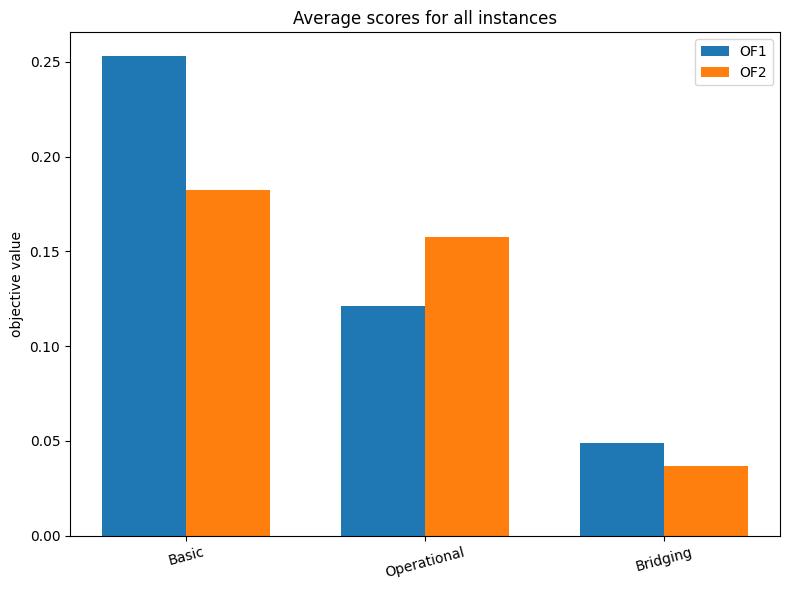

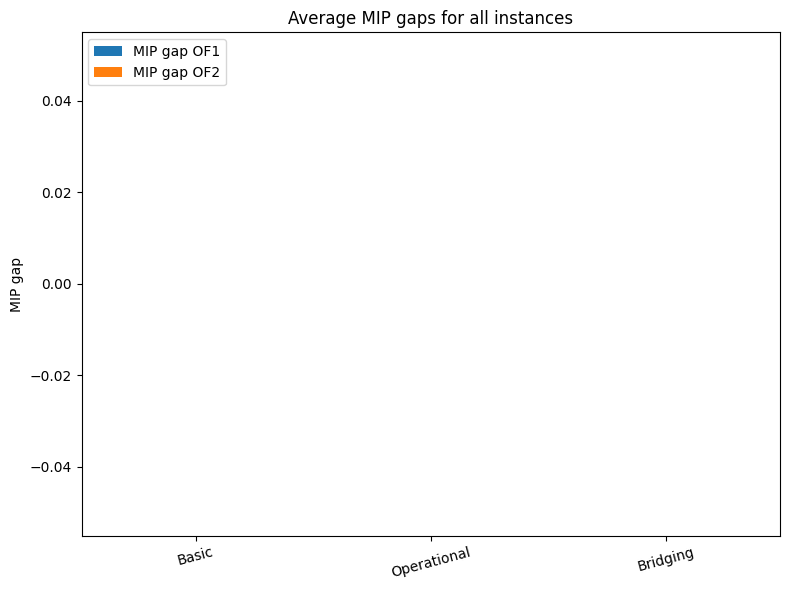

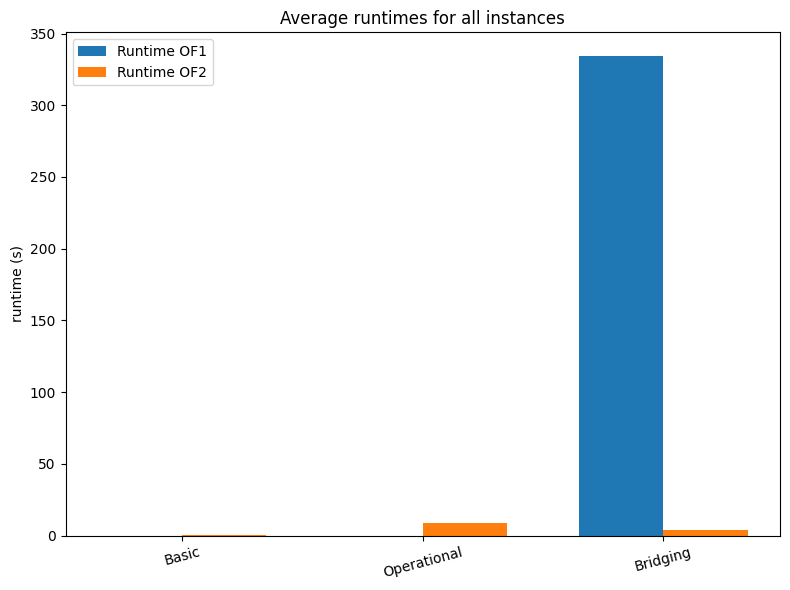

In [6]:
# ------------------------------------------------------------
# 1) Turn the raw list of dicts into a tidy DataFrame
# ------------------------------------------------------------
df = pd.DataFrame(records)
models_order = ["Basic", "Operational", "Bridging"]  # desired order on X-axis
df["model"] = pd.Categorical(df["model"], categories=models_order, ordered=True)

# ------------------------------------------------------------
# 2) Objective function plots
# ------------------------------------------------------------
objective_functions_path = "plots/objective_functions"
# 2.1) A bar chart for each instance 
for inst, sub in df.groupby("instance", sort=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    # bar positions – two bars per model
    x_base = np.arange(len(models_order))
    width   = 0.35                      # width of a single bar
    bar1_x  = x_base - width/2          # OF1 bars (left)
    bar2_x  = x_base + width/2          # OF2 bars (right)

    # heights for the bars
    of1_vals = sub.set_index("model")["OF1"].reindex(models_order) / sub["OF1"].max()  # normalize to max value for better visibility
    of2_vals = sub.set_index("model")["OF2"].reindex(models_order) / sub["OF2"].max()  # normalize to max value for better visibility

    ax.bar(bar1_x, of1_vals, width, label="OF1")
    ax.bar(bar2_x, of2_vals, width, label="OF2")

    # cosmetics -----------------------------------------------------
    ax.set_title(f"Scores for instance {inst}")
    ax.set_xticks(x_base)
    ax.set_xticklabels(models_order, rotation=15)
    ax.set_ylabel("objective value")
    ax.legend()

    plt.tight_layout()
    # Save the figure
    plt.savefig(f"{objective_functions_path}/{inst}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)  

# 2.2) A bar chart for the average scores
fig, ax = plt.subplots(figsize=(8, 6))

# bar positions – two bars per model
x_base = np.arange(len(models_order))
width   = 0.35                      # width of a single bar
bar1_x  = x_base - width/2          # OF1 bars (left)
bar2_x  = x_base + width/2          # OF2 bars (right)

# heights for the bars
of1_vals = df.groupby("model", observed=True)["OF1"].mean().reindex(models_order) / df["OF1"].max()  # normalize to max value for better visibility
of2_vals = df.groupby("model", observed=True)["OF2"].mean().reindex(models_order) / df["OF2"].max()  # normalize to max value for better visibility
ax.bar(bar1_x, of1_vals, width, label="OF1")
ax.bar(bar2_x, of2_vals, width, label="OF2")

# cosmetics -----------------------------------------------------
ax.set_title("Average scores for all instances")
ax.set_xticks(x_base)
ax.set_xticklabels(models_order, rotation=15)
ax.set_ylabel("objective value")
ax.legend()

plt.tight_layout()
# Save the figure
plt.savefig(f"{objective_functions_path}/average_scores.png", dpi=150, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 4) MIP gaps plots
# ------------------------------------------------------------
mip_gaps_path = "plots/mip_gaps"

# 4.1) A bar chart for each instance
for inst, sub in df.groupby("instance", sort=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    # bar positions – two bars per model
    x_base = np.arange(len(models_order))
    width   = 0.35                      # width of a single bar
    bar1_x  = x_base - width/2          # MIP gap OF1 bars (left)
    bar2_x  = x_base + width/2          # MIP gap OF2 bars (right)

    # heights for the bars
    mipgap1_vals = sub.set_index("model")["MIPgap_1"].reindex(models_order)
    mipgap2_vals = sub.set_index("model")["MIPgap_2"].reindex(models_order)

    ax.bar(bar1_x, mipgap1_vals, width, label="MIP gap OF1")
    ax.bar(bar2_x, mipgap2_vals, width, label="MIP gap OF2")

    # cosmetics -----------------------------------------------------
    ax.set_title(f"MIP gaps for instance {inst}")
    ax.set_xticks(x_base)
    ax.set_xticklabels(models_order, rotation=15)
    ax.set_ylabel("MIP gap")
    ax.legend()

    plt.tight_layout()
    # Save the figure
    plt.savefig(f"{mip_gaps_path}/mip_gap_{inst}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

# 4.2) A bar chart for the average MIP gaps 

fig, ax = plt.subplots(figsize=(8, 6))

# bar positions – two bars per model
x_base = np.arange(len(models_order))
width   = 0.35                      # width of a single bar
bar1_x  = x_base - width/2          # MIP gap OF1 bars (left)
bar2_x  = x_base + width/2          # MIP gap OF2 bars (right)

# heights for the bars
mipgap1_vals = df.groupby("model", observed=True)["MIPgap_1"].mean().reindex(models_order)
mipgap2_vals = df.groupby("model", observed=True)["MIPgap_2"].mean().reindex(models_order)
ax.bar(bar1_x, mipgap1_vals, width, label="MIP gap OF1")
ax.bar(bar2_x, mipgap2_vals, width, label="MIP gap OF2")

# cosmetics -----------------------------------------------------
ax.set_title("Average MIP gaps for all instances")
ax.set_xticks(x_base)
ax.set_xticklabels(models_order, rotation=15)
ax.set_ylabel("MIP gap")
ax.legend()

plt.tight_layout()
# Save the figure
plt.savefig(f"{mip_gaps_path}/average_mip_gaps.png", dpi=150, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 5) Runtime plots
# ------------------------------------------------------------
runtime_path = "plots/runtime"

# 5.1) A bar chart for each instance
for inst, sub in df.groupby("instance", sort=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    # bar positions – two bars per model
    x_base = np.arange(len(models_order))
    width   = 0.35                      # width of a single bar
    bar1_x  = x_base - width/2          # runtime OF1 bars (left)
    bar2_x  = x_base + width/2          # runtime OF2 bars (right)

    # heights for the bars
    rt1_vals = sub.set_index("model")["runtime_1"].reindex(models_order)
    rt2_vals = sub.set_index("model")["runtime_2"].reindex(models_order)

    ax.bar(bar1_x, rt1_vals, width, label="Runtime OF1")
    ax.bar(bar2_x, rt2_vals, width, label="Runtime OF2")

    # cosmetics -----------------------------------------------------
    ax.set_title(f"Runtimes for instance {inst}")
    ax.set_xticks(x_base)
    ax.set_xticklabels(models_order, rotation=15)
    ax.set_ylabel("runtime (s)")
    ax.legend()

    plt.tight_layout()
    # Save the figure
    plt.savefig(f"{runtime_path}/runtime_{inst}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

# 5.2) A bar chart for the average runtimes
fig, ax = plt.subplots(figsize=(8, 6))

# bar positions – two bars per model
x_base = np.arange(len(models_order))
width   = 0.35                      # width of a single bar
bar1_x  = x_base - width/2          # runtime OF1 bars (left)
bar2_x  = x_base + width/2          # runtime OF2 bars (right)
# heights for the bars
rt1_vals = df.groupby("model", observed=True)["runtime_1"].mean().reindex(models_order)
rt2_vals = df.groupby("model", observed=True)["runtime_2"].mean().reindex(models_order)
ax.bar(bar1_x, rt1_vals, width, label="Runtime OF1")
ax.bar(bar2_x, rt2_vals, width, label="Runtime OF2")
# cosmetics -----------------------------------------------------
ax.set_title("Average runtimes for all instances")
ax.set_xticks(x_base)
ax.set_xticklabels(models_order, rotation=15)
ax.set_ylabel("runtime (s)")
ax.legend()
plt.tight_layout()
# Save the figure
plt.savefig(f"{runtime_path}/average_runtime.png", dpi=150, bbox_inches="tight")
plt.show()

# Conclusion

In this notebook, we explored the Interpreter Scheduling Problem (ISP) by formulating mathematical models and analyzing their performance on various instances. Through the use of integer programming and advanced mechanisms such as bridging, we demonstrated how interpreters can be efficiently assigned to maximize language coverage while respecting operational constraints.

The first two models performed well on small and big instances achieving expected results, model 1 outperformed model 2 because it has less constraints. However, model 2 is more realistic as it takes into account the operational constraints of the interpreters (acceptable working hours).

Model 3 introduced the concept of bridging, allowing for indirect language connections. This model showed promising results, achieving a higher score than the model 2 but still not as high as model 1 (in most cases). However, due to the complexity of the model, the time limit (600 second) was reached in some cases before finding the optimal solution. For some reason when generating all of the results "gurobi" bugs out when the time limit is reached on OF1 the solver stops prematuraly and does not return the best solution for OF2.